In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pandas as pd
from astropy.io import fits
import pcmdpy as ppy
from scipy.interpolate import interp1d
from tqdm import tqdm
%matplotlib inline

GPU acceleration not available, sorry
No module named 'pycuda'


In [2]:
def center(psf):
    x, y = np.where(psf == psf.max())
    return x[0], y[0]

In [3]:
def make_radial(psf):
    x_c, y_c = center(psf)
    X = np.tile(np.arange(psf.shape[0]), psf.shape[1]).reshape(psf.shape)
    Y = np.transpose(X)
    R = np.sqrt((X - x_c)**2 + (Y - y_c)**2)
    p = psf.flatten()
    r = R.flatten()
    sort_idx = r.argsort()
    return p[sort_idx], r[sort_idx]

In [4]:
def get_FWHM(psf):
    psf = np.copy(psf)
    psf /= np.sum(psf)
    p, r = make_radial(psf)
    p /= p.sum()
    inter = interp1d(r, np.cumsum(p))
    x_new = np.arange(0, 10, 0.01)
    x_new = np.tile(x_new, len(x_new)).reshape((len(x_new), len(x_new)))
    y_new = np.transpose(x_new)
    r_new = np.sqrt(x_new**2 + y_new**2)
    p_new = inter(r_new)
    r_fwhm = np.min(r_new[p_new >= 0.5])
    return r_fwhm

In [5]:
for f in ['F435W', 'F475W', 'F555W', 'F814W', 'F850LP']:
    psf = fits.open('../pcmdpy/pcmdpy/psf/ACS_WFC_{:s}.fits'.format(f))[0].data
    print(f, get_FWHM(psf))

F435W 1.21
F475W 1.1906720791217034
F555W 1.0000499987500624
F814W 1.414284271283535
F850LP 1.414284271283535


In [6]:
get_FWHM(psf**.95)

1.414284271283535

In [7]:
1/1.1, 1/1.25

(0.9090909090909091, 0.8)

In [8]:
get_FWHM(psf**1.036) / get_FWHM(psf)

0.9017586612457276

In [11]:
get_FWHM(psf**1.056) / get_FWHM(psf)

0.7469900940306653

In [12]:
# for f in tqdm(['F435W', 'F475W', 'F814W', 'F850LP', 'F555W']):
#     psf = fits.open('../pcmdpy/pcmdpy/psf/ACS_WFC_{:s}.fits'.format(f))[0].data
#     psf_10p_smaller = np.power(psf, 1.234)
#     psf_25p_smaller = np.power(psf, 1.777)
#     fits.ImageHDU(data=psf_10p_smaller).writeto('../pcmdpy/pcmdpy/psf/{:s}_10p_narrow.fits'.format(f))
#     fits.ImageHDU(data=psf_25p_smaller).writeto('../pcmdpy/pcmdpy/psf/{:s}_25p_narrow.fits'.format(f))

In [26]:
res = {}
names = {
    1: "Default PSF\n(Npix = 1000)",
    2: "Narrow PSFs\n(Npix = 1000)",
    3: "Extra Narrow PSFs\n(Npix = 1000)",
    4: "Single Narrow PSF\n(Npix = 1000)",
    5: "Default PSF\n(Npix = 100)",
    6: "Narrow PSFs\n(Npix = 100)",
    7: "Extra Narrow PSFs\n(Npix = 100)",
    8: "Single Narrow PSF\n(Npix = 100)",
}
for r in range(1, 9):
    if r < 5:
        model_mock.set_params(params_npix3)
    else:
        model_mock.set_params(params_npix2)
    try:
        res['psf{:d}'.format(r)] = ppy.plotting.ResultsPlotter('results/mock_m31_psf_{:d}.csv'.format(r),
                                                            run_name=names[r], true_model=model_mock)
    except:
        print('psf{:d} not found'.format(r))        

In [29]:
def plot_sets(run_names, regions=[1,2], chains_only=False, dmod_true=24.42, nonparam=False):
    if chains_only:
        nr = 5
    else:
        nr = 8
    if nonparam:
        nr += 4
    nx = len(run_names)
    fs = (10+10*nx, 3*nr)
    fig, axes = plt.subplots(ncols=len(run_names)*len(regions), nrows=nr, figsize=fs, sharex=True, sharey='row')
    for i, r in enumerate(regions):
        for j, n in enumerate(run_names):
            plot_axes = axes[:, nx*i + j]
            if '_nm' in n:
                if nonparam:
                    plot_axes = list(plot_axes[:7])+list(plot_axes[8:])
                else:
                    plot_axes = list(plot_axes[:3])+list(plot_axes[4:])
            res[n.format(r)].plot_chains(axes=plot_axes, chains_only=chains_only)
#     if not nonparam:
#         for ax in axes[3]:
#             ax.axhline(y=dmod_true, ls='--', color='r')
    plt.tight_layout()
    return fig, axes

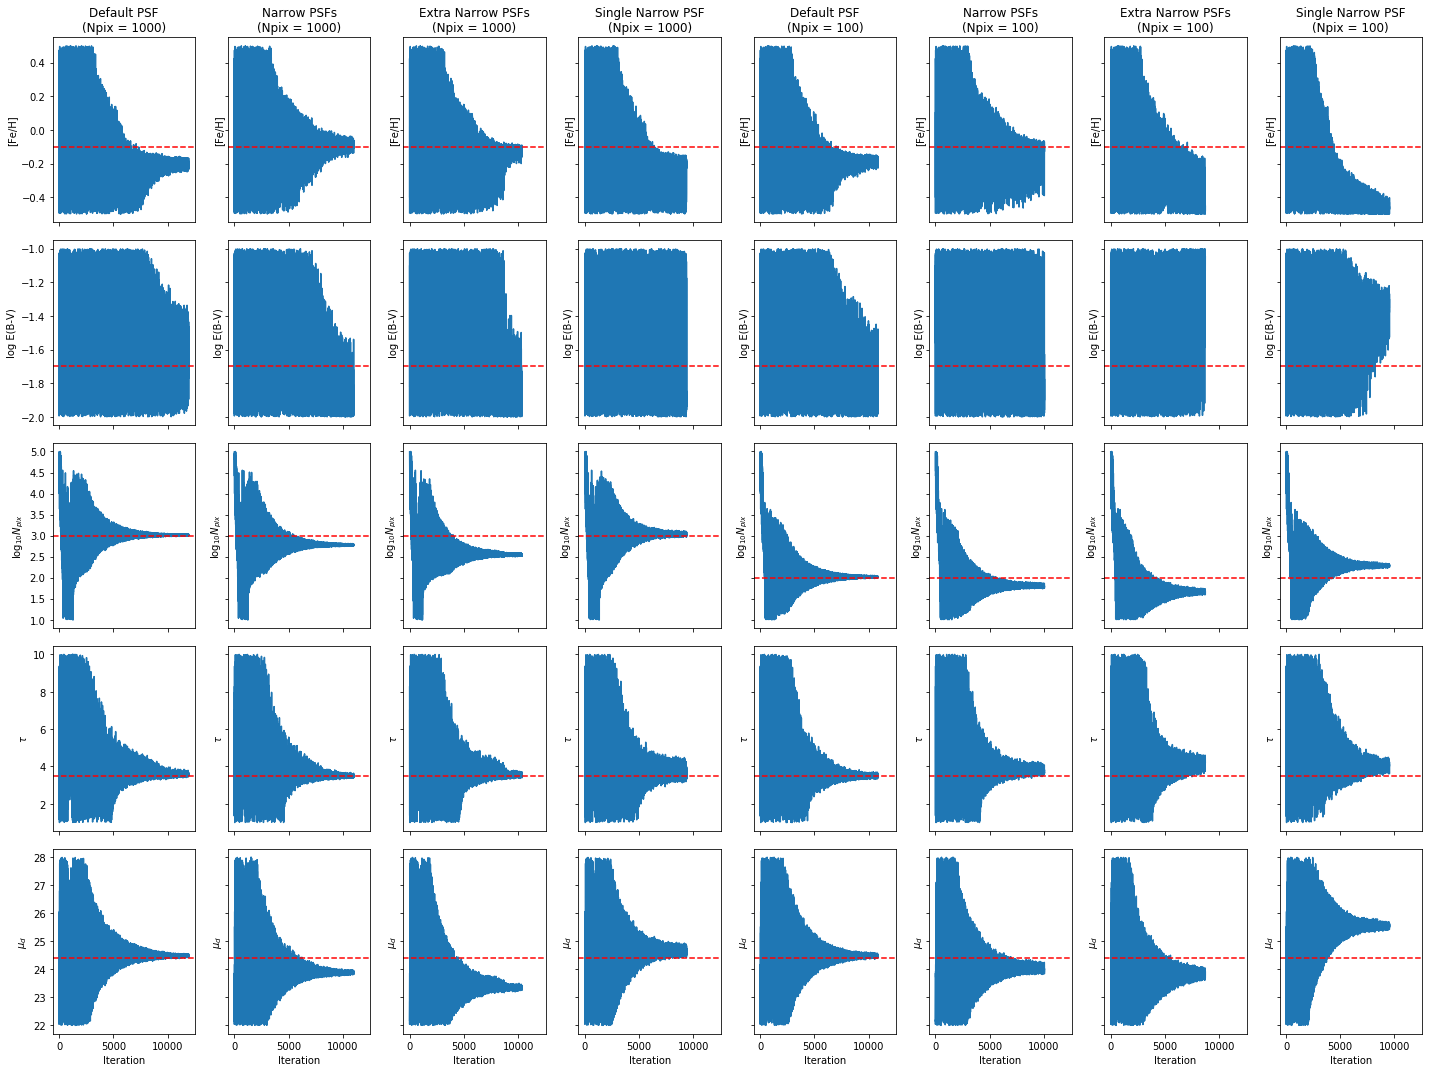

In [41]:
plot_sets(['psf{:d}'], regions=range(1, 9), chains_only=True);
plt.savefig('figures/psf_mocks.jpg')